In [ ]:
import os
import csv
import configparser
import json

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.ticker import FixedLocator, FuncFormatter, StrMethodFormatter
from scipy.stats import linregress
import networkx as nx

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['text.usetex'] = True

In [ ]:
# prefix = "./executed/CUHK-SE-Group-TrainTicket_PPTAM_31-03-2025/executed"
# design_folder = "../design/trainticket/CUHK-SE"
# prefix_for_plots = "trainticket-CUHK-SE"

prefix = "./executed/FundaSELab-TrainTicket_v0.2.0_PPTAM_29-03-2025/executed"
design_folder = "../design/trainticket/FUDAN/parse_tag002"
prefix_for_plots = "trainticket-FUDAN002"

# prefix = "./executed/FundaSELab-TrainTicket_v1.0.0_PPTAM_10-05-2025/executed"
# design_folder = "../design/trainticket/FUDAN/parse_tag100"
# prefix_for_plots = "trainticket-FUDAN100"

# prefix = "./executed/SEALAB-Group-TrainTicket_PPTAM_14-04-2025/executed"
# design_folder = "../design/trainticket/SEALAB"
# prefix_for_plots = "trainticket-SEALAB"

# prefix = "./executed/hotelreservation"
# design_folder = "../design/hotelreservation"
# prefix_for_plots = "hotelreservation"


experiment_folders = sorted([name for name in os.listdir(prefix) if os.path.isdir(os.path.join(prefix, name))])

load_values = {}  

for folder in experiment_folders:
    config_path = os.path.join(prefix, folder, "configuration.ini")

    config = configparser.ConfigParser()
    config.read(config_path)
    load_value = config['CONFIGURATION']['LOAD']
    load_values[folder] = load_value

print("\nCollected load values:")
for folder, load in load_values.items():
    print(f"{folder} ({load} users)")


Collected load values:
202503290118-tt-test1 (1 users)
202503290138-tt-test2 (2 users)
202503290158-tt-test3 (4 users)
202503290218-tt-test4 (6 users)
202503290238-tt-test5 (8 users)
202503290258-tt-test6 (10 users)
202503290318-tt-test7 (15 users)
202503290338-tt-test8 (20 users)
202503290358-tt-test9 (25 users)
202503290418-tt-test10 (30 users)


In [42]:
endpoints = set()

for folder in experiment_folders:
    csv_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} does not exist, skipping.")
        continue

    with open(csv_path, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            name = row['Name']
            if name != "Aggregated" and name != "":
                endpoints.add(name)

endpoints = sorted(endpoints)

print("\nUnique API endpoints found:")
for name in endpoints:
    print(f"- {name}")


Unique API endpoints found:
- /api/v1/adminuserservice/users
- /api/v1/assuranceservice/assurances/types
- /api/v1/contactservice/contacts
- /api/v1/contactservice/contacts/account/user
- /api/v1/executeservice/execute/collected/order
- /api/v1/executeservice/execute/execute/order
- /api/v1/foodservice/foods/departure/shanghai/suzhou/D1345
- /api/v1/inside_pay_service/inside_payment
- /api/v1/orderservice/order/refresh
- /api/v1/preserveservice/preserve
- /api/v1/travelservice/trips/left
- /api/v1/users/login
- /index.html


In [43]:
endpoint_requirements = {}

for endpoint in endpoints:
    found = False
    for folder in experiment_folders:
        csv_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(csv_path):
            continue

        with open(csv_path, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Name'] == endpoint:
                    avg_response = float(row['Average Response Time'])
                    percentile_75 = float(row['75%'])
                    percentile_25 = float(row['25%'])

                    # Approximate standard deviation from IQR
                    iqr = percentile_75 - percentile_25
                    stddev = iqr / 1.35

                    # Calculate requirement
                    requirement = avg_response + 3 * stddev

                    endpoint_requirements[endpoint] = {
                        'Average Response Time': avg_response,
                        'Standard deviation': stddev,
                        'Requirement': requirement
                    }

                    found = True
                    break  # Found it, no need to search more
        if found:
            break

df = pd.DataFrame.from_dict(endpoint_requirements, orient='index')
df = df.reset_index().rename(columns={'index': 'Endpoint'})
df = df[['Endpoint', 'Average Response Time', 'Standard deviation', 'Requirement']]
df = df.round({
    'Average Response Time': 2,
    'Standard deviation': 2,
    'Requirement': 2
})

# Add line number starting from 1
df.insert(0, 'No.', range(1, len(df) + 1))

print("\nCalculated Requirements:")
display(df)


Calculated Requirements:


,No.,Endpoint,Average Response Time,Standard deviation,Requirement
0,1,/api/v1/adminuserservice/users,15967.74,0.00,15967.74
1,2,/api/v1/assuranceservice/assurances/types,39.62,3.70,50.73
2,3,/api/v1/contactservice/contacts,4486.83,0.00,4486.83
3,4,/api/v1/contactservice/contacts/account/user,16.89,5.19,32.44
4,5,/api/v1/executeservice/execute/collected/order,105.72,8.15,130.17
5,6,/api/v1/executeservice/execute/execute/order,46.40,9.63,75.29
6,7,/api/v1/foodservice/foods/departure/shanghai/s...,207.13,82.22,453.80
7,8,/api/v1/inside_pay_service/inside_payment,159.63,31.85,255.19
8,9,/api/v1/orderservice/order/refresh,121.34,51.11,274.67
9,10,/api/v1/preserveservice/preserve,839.53,325.93,1817.31


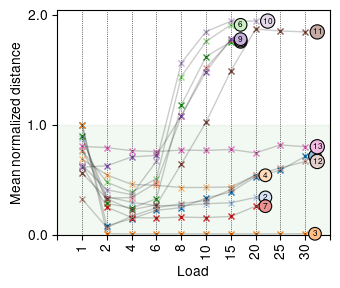

In [44]:
requirements = [endpoint_requirements[ep]['Requirement'] for ep in endpoints]

fig_width = 3.5
fig_height = 3
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

cmap = colormaps.get_cmap('tab20') # or 'tab10', 'Set3', etc.
endpoint_colors = {ep: cmap(i) for i, ep in enumerate(endpoints)}

def brighten_color(color, factor=0.5):
    r, g, b, a = color
    r = r + (1.0 - r) * factor
    g = g + (1.0 - g) * factor
    b = b + (1.0 - b) * factor
    return (r, g, b, 1.0)  # Force alpha = 1

endpoint_background_colors = {ep: brighten_color(color) for ep, color in endpoint_colors.items()}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")
    
    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            mean = float(row['Average Response Time'])
            ndist = (2 * mean) / (mean + requirements[i])

            # ax.plot(experiment_number, ndist, marker='x', markersize=4, color="steelblue")
            ax.plot(experiment_number, ndist, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, ndist))

last_ndist_values = {endpoint: points[-1][1] for endpoint, points in mark_coords.items()}

ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Mean normalized distance')
ax.set_yscale("linear") #linear, log, symlog, logit
ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]

    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add index as the label near the last point
    last_x, last_y = points[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

x_values = np.array(ax.get_xlim())
y_value = 1
ax.fill_between(x_values, y_value, color='green', alpha=0.05)

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-nd.pdf")
plt.show()


In [45]:
endpoint_slopes = {}

for endpoint in endpoints:
    loads = []
    max_response_times = []
    
    for folder in experiment_folders:
        file_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(file_path):
            continue

        data = pd.read_csv(file_path, delimiter=",", decimal=".")
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])
            load = int(load_values[folder])

            loads.append(load)
            max_response_times.append(max_response_time)

    if len(loads) >= 2:
        slope, intercept, r_value, p_value, std_err = linregress(loads, max_response_times)
        endpoint_slopes[endpoint] = float(slope)
    else:
        endpoint_slopes[endpoint] = None  # not enough data to fit

slope_data = []
for endpoint, slope in endpoint_slopes.items():
    if slope is not None:
        slope_data.append({"Endpoint": endpoint, "Slope": f"{slope:.2f}"})
    else:
        slope_data.append({"Endpoint": endpoint, "Slope": "Not enough data"})

slope_df = pd.DataFrame(slope_data)
display(slope_df)


,Endpoint,Slope
0,/api/v1/adminuserservice/users,323.31
1,/api/v1/assuranceservice/assurances/types,-102.58
2,/api/v1/contactservice/contacts,-53.10
3,/api/v1/contactservice/contacts/account/user,-2.57
4,/api/v1/executeservice/execute/collected/order,51.91
5,/api/v1/executeservice/execute/execute/order,704.35
6,/api/v1/foodservice/foods/departure/shanghai/s...,-345.18
7,/api/v1/inside_pay_service/inside_payment,41.33
8,/api/v1/orderservice/order/refresh,859.81
9,/api/v1/preserveservice/preserve,3390.66


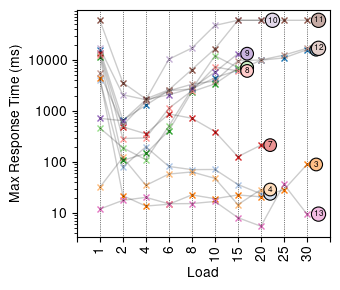

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")

    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])

            ax.plot(experiment_number, max_response_time, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, max_response_time))

# Set axis properties
ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Max Response Time (ms)')
ax.set_yscale("log")
# ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]
    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    
    # Plot connecting lines
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add small index label near the last point
    last_x, last_y = x_vals[-1], y_vals[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-max_response_times.pdf")
plt.show()


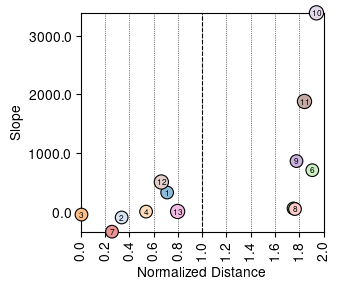

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

endpoints = list(last_ndist_values.keys())
x_vals = [last_ndist_values[ep] for ep in endpoints]
y_vals = [endpoint_slopes[ep] for ep in endpoints]

for idx, (x, y) in enumerate(zip(x_vals, y_vals), start=1):
    endpoint = endpoints[idx - 1]  # Get the correct endpoint
    ax.text(
        x, y, str(idx),
        fontsize=6, va='center', ha='center',
        bbox=dict(
            boxstyle="circle",
            fc=endpoint_background_colors[endpoint],  # dynamic face color
            ec="black", lw=0.8
        )
    )

ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8)

ax.set_title("")
ax.set_xlabel('Normalized Distance')
ax.set_ylabel('Slope')

ax.set_yscale("linear")
ax.set_ylim(min(0, min(endpoint_slopes.values())), max(endpoint_slopes.values()))
ax.set_xlim(0, 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2))

def my_formatter(x, pos):
    return f"{x:.1f}"

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.01f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-slope-vs-nd.pdf")
plt.show()


In [48]:
mapping_path = os.path.join(design_folder, "service_mapping.json")

with open(mapping_path, "r") as f:
    endpoint_to_service = json.load(f)
    
def get_microservice_name(endpoint):
    for prefix, service_name in endpoint_to_service.items():
        if endpoint == prefix:
            return service_name
    return None

data = []

for idx, (x, y) in enumerate(zip(x_vals, y_vals), start=1):
    endpoint = endpoints[idx - 1]
    service_name = get_microservice_name(endpoint)
    data.append({"Index": idx, "Endpoint": endpoint, "Microservice": service_name})

df = pd.DataFrame(data)
display(df)

,Index,Endpoint,Microservice
0,1,/api/v1/adminuserservice/users,None
1,2,/api/v1/assuranceservice/assurances/types,ts-assurance-service
2,3,/api/v1/contactservice/contacts,ts-contacts-service
3,4,/api/v1/contactservice/contacts/account/user,ts-contacts-service
4,5,/api/v1/executeservice/execute/collected/order,ts-execute-service
5,6,/api/v1/executeservice/execute/execute/order,ts-execute-service
6,7,/api/v1/foodservice/foods/departure/shanghai/s...,ts-food-service
7,8,/api/v1/inside_pay_service/inside_payment,ts-inside-payment-service
8,9,/api/v1/orderservice/order/refresh,ts-order-service
9,10,/api/v1/preserveservice/preserve,ts-preserve-service


In [49]:
def read_csv_and_build_graph(csv_filename):
    G = nx.DiGraph()

    with open(csv_filename, 'r') as file:
        csv_reader = csv.DictReader(file, delimiter=';')
        for row in csv_reader:
            from_service = row['from']
            to_service = row['to']
            G.add_edge(from_service, to_service)

    return G

dependencies = os.path.join(design_folder, "call_dependencies.csv")
G = read_csv_and_build_graph(dependencies)
coupling = {node: int(G.degree(node)) for node in G.nodes}

data = []

for idx, endpoint in enumerate(endpoints, start=1):
    last_ndist = last_ndist_values.get(endpoint, None)
    microservice = get_microservice_name(endpoint)
    coupling_value = coupling.get(microservice, None) 
    
    data.append({
        "Number": idx,
        "Endpoint": endpoint,
        "Last Normalized Distance": last_ndist,
        "Microservice": microservice,
        "Coupling Value": coupling_value
    })

df = pd.DataFrame(data)
display(df)

styler = df.style.hide(axis="index")
latex_code = styler.to_latex(hrules=True, caption=None, label=None)
latex_code = latex_code.replace(r'\toprule', r'\hline')
latex_code = latex_code.replace(r'\midrule', r'\hline')
latex_code = latex_code.replace(r'\bottomrule', r'\hline')
latex_code = latex_code.replace(r'_', r'\textunderscore ')
latex_code = latex_code.replace(r'.000000', r'')
print(latex_code)

,Number,Endpoint,Last Normalized Distance,Microservice,Coupling Value
0,1,/api/v1/adminuserservice/users,0.711925,None,NaN
1,2,/api/v1/assuranceservice/assurances/types,0.337516,ts-assurance-service,2.0
2,3,/api/v1/contactservice/contacts,0.006768,ts-contacts-service,2.0
3,4,/api/v1/contactservice/contacts/account/user,0.538767,ts-contacts-service,2.0
4,5,/api/v1/executeservice/execute/collected/order,1.752557,ts-execute-service,2.0
5,6,/api/v1/executeservice/execute/execute/order,1.906935,ts-execute-service,2.0
6,7,/api/v1/foodservice/foods/departure/shanghai/s...,0.257984,ts-food-service,5.0
7,8,/api/v1/inside_pay_service/inside_payment,1.764660,ts-inside-payment-service,5.0
8,9,/api/v1/orderservice/order/refresh,1.777007,ts-order-service,9.0
9,10,/api/v1/preserveservice/preserve,1.941212,ts-preserve-service,12.0


\begin{tabular}{rlrlr}
\hline
Number & Endpoint & Last Normalized Distance & Microservice & Coupling Value \\
\hline
1 & /api/v1/adminuserservice/users & 0.711925 & None & nan \\
2 & /api/v1/assuranceservice/assurances/types & 0.337516 & ts-assurance-service & 2 \\
3 & /api/v1/contactservice/contacts & 0.006768 & ts-contacts-service & 2 \\
4 & /api/v1/contactservice/contacts/account/user & 0.538767 & ts-contacts-service & 2 \\
5 & /api/v1/executeservice/execute/collected/order & 1.752557 & ts-execute-service & 2 \\
6 & /api/v1/executeservice/execute/execute/order & 1.906935 & ts-execute-service & 2 \\
7 & /api/v1/foodservice/foods/departure/shanghai/suzhou/D1345 & 0.257984 & ts-food-service & 5 \\
8 & /api/v1/inside\textunderscore pay\textunderscore service/inside\textunderscore payment & 1.764660 & ts-inside-payment-service & 5 \\
9 & /api/v1/orderservice/order/refresh & 1.777007 & ts-order-service & 9 \\
10 & /api/v1/preserveservice/preserve & 1.941212 & ts-preserve-service & 12 \\
1

In [50]:
normalized_distance = []
coupling_value = []

for idx, endpoint in enumerate(endpoints, start=1):
    last_ndist = last_ndist_values.get(endpoint, None)
    microservice = get_microservice_name(endpoint)
    
    if microservice is None:
        continue  # Skip if microservice mapping not found
    
    coupling_val = coupling.get(microservice, None)
    
    if last_ndist is not None and coupling_val is not None:
        normalized_distance.append(last_ndist)
        coupling_value.append(coupling_val)

df_values = pd.DataFrame({
    "Normalized Distance": normalized_distance,
    "Coupling Value": coupling_value
})

display(df_values)

,Normalized Distance,Coupling Value
0,0.337516,2
1,0.006768,2
2,0.538767,2
3,1.752557,2
4,1.906935,2
5,0.257984,5
6,1.764660,5
7,1.777007,9
8,1.941212,12
9,1.842632,10


In [51]:
# We are entering Daniel's world now!

# https://colab.research.google.com/drive/1h5-HWkveYI6JoyXX1eCBK0CUxpgNS19J?usp=sharing#scrollTo=xWA8hQyIHZWm 

from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import spearmanr

print(normalized_distance)
print(coupling_value)
print(np.array(normalized_distance).reshape(1, -1))
print(np.array(coupling_value).reshape(1, -1))

# Compute normalized mutual information
nmi_score = normalized_mutual_info_score(normalized_distance, coupling_value)
print(f"Normalized Mutual Information: {nmi_score}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(normalized_distance, coupling_value)
print(f"Spearman Correlation: {spearman_corr}")

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, rankdata, pearsonr

# --- Compute Pearson correlation
pearson_corr, _ = pearsonr(normalized_distance, coupling_value)
print(f"Pearson Correlation: {pearson_corr}")

# --- Compute Cosine similarity
# Reshape vectors to 2D arrays because cosine_similarity expects 2D inputs
cosine_sim = cosine_similarity(
    np.array(normalized_distance).reshape(1, -1),
    np.array(coupling_value).reshape(1, -1)
)[0, 0]
print(f"Cosine Similarity: {cosine_sim}")

[0.3375163698541233, 0.006767630122395612, 0.5387674141493748, 1.7525568540997718, 1.9069352657289553, 0.25798408991756083, 1.7646601450125354, 1.777007451541522, 1.9412121000992448, 1.8426322594885625, 0.6644120347793039]
[2, 2, 2, 2, 2, 5, 5, 9, 12, 10, 4]
[[0.337516369854123 0.006767630122396 0.538767414149375 1.752556854099772
  1.906935265728955 0.257984089917561 1.764660145012535 1.777007451541522
  1.941212100099245 1.842632259488562 0.664412034779304]]
[[ 2  2  2  2  2  5  5  9 12 10  4]]
Normalized Mutual Information: 0.7822382792991559
Spearman Correlation: 0.540058200338919
Pearson Correlation: 0.5385689659562611
Cosine Similarity: 0.8553530177143054


/Users/ajanes/Documents/code/pptam/pptam-tool/toolchain/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [52]:
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import spearmanr, rankdata

import numpy as np
np.set_printoptions(precision=15)

def compute_spearman_with_tie_correction(x, y):
    """
    Compute Spearman correlation with tie correction.
    """
    # Use rankdata to compute ranks correctly
    ranks_x = rankdata(x, method="average")
    ranks_y = rankdata(y, method="average")

    # Compute differences in ranks
    d = ranks_x - ranks_y

    # Calculate the tie correction terms
    def tie_correction(ranks):
        unique, counts = np.unique(ranks, return_counts=True)
        return np.sum(counts * (counts**2 - 1) / 12)

    T_x = tie_correction(ranks_x)
    T_y = tie_correction(ranks_y)


    print(f"TX: {T_x}")
    print(f"TY: {T_y}")


    # Number of observations
    n = len(x)

    # Spearman formula with tie correction
    numerator = 6 * np.sum(d**2)
    denominator = n * (n**2 - 1) - T_x - T_y
    rho = 1 - numerator / denominator

    return rho

# Compute Spearman correlation with tie correction
spearman_corr_with_correction = compute_spearman_with_tie_correction(normalized_distance, coupling_value)
print(f"Spearman Correlation (with tie correction): {spearman_corr_with_correction}")

# Compute Spearman correlation using scipy
spearman_corr, _ = spearmanr(normalized_distance, coupling_value)
print(f"Spearman Correlation (from Python): {spearman_corr}")

from scipy.stats import rankdata

manual_ranks = rankdata(normalized_distance, method="average")
scipy_ranks = rankdata(normalized_distance)
print("Manual Ranks:", manual_ranks)
print("Scipy Ranks: ", scipy_ranks)

TX: 0.0
TY: 10.5
Spearman Correlation (with tie correction): 0.5578465063001146
Spearman Correlation (from Python): 0.540058200338919
Manual Ranks: [ 3.  1.  4.  6. 10.  2.  7.  8. 11.  9.  5.]
Scipy Ranks:  [ 3.  1.  4.  6. 10.  2.  7.  8. 11.  9.  5.]


In [53]:
def spearman_corrected_for_ties(x, y):
    n = len(x)

    # Compute ranks
    # Use rankdata to compute ranks correctly
    ranks_x = rankdata(x, method="average")
    ranks_y = rankdata(y, method="average")

    # Compute differences in ranks
    d = ranks_x - ranks_y
    sum_d2 = np.sum(d**2)

    # Calculate tie corrections
    def tie_correction(ranks):
        unique, counts = np.unique(ranks, return_counts=True)
        return np.sum(counts * (counts**2 - 1) / 12)

    T_x = tie_correction(ranks_x)
    T_y = tie_correction(ranks_y)

    # Compute Spearman correlation corrected for ties
    numerator = (n**3 - n) / 6 - sum_d2 - T_x - T_y
    denominator = np.sqrt(
        ((n**3 - n) / 6 - 2 * T_x) * ((n**3 - n) / 6 - 2 * T_y)
    )

    r_s2 = numerator / denominator
    return r_s2


spearman_r2 = spearman_corrected_for_ties(normalized_distance, coupling_value)
print(f"Spearman Correlation (corrected for ties): {spearman_r2}")

Spearman Correlation (corrected for ties): 0.540058200338919


In [54]:
from scipy.stats import rankdata
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

# Function to compute Spearman correlation using the covariance formula
def spearman_rank_based(x, y):
    # Convert raw scores to ranks
    ranks_x = rankdata(x)
    ranks_y = rankdata(y)

    # Compute covariance of ranks
    mean_rank_x = np.mean(ranks_x)
    mean_rank_y = np.mean(ranks_y)
    covariance = np.mean((ranks_x - mean_rank_x) * (ranks_y - mean_rank_y))

    # Compute standard deviations of ranks
    std_x = np.std(ranks_x, ddof=0)
    std_y = np.std(ranks_y, ddof=0)

    # Compute Spearman correlation
    spearman_corr = covariance / (std_x * std_y)
    return spearman_corr

# Compute Spearman correlation using rank-based formula
spearman_corr_rank_based = spearman_rank_based(normalized_distance, coupling_value)
print(f"Spearman Correlation (Rank-based formula): {spearman_corr_rank_based}")

# Compute Spearman correlation using scipy's built-in method
from scipy.stats import spearmanr
spearman_corr_scipy, _ = spearmanr(normalized_distance, coupling_value)
print(f"Spearman Correlation (Scipy).            : {spearman_corr_scipy}")

# Compute normalized mutual information
nmi_score = normalized_mutual_info_score(normalized_distance, coupling_value)
print(f"Normalized Mutual Information Score: {nmi_score}")

Spearman Correlation (Rank-based formula): 0.540058200338919
Spearman Correlation (Scipy).            : 0.540058200338919
Normalized Mutual Information Score: 0.7822382792991559


/Users/ajanes/Documents/code/pptam/pptam-tool/toolchain/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
